# <div> Effects of climate change on agriculture </div>

We'll be visualizing trends in food production across different countries since 1960s to 2020 to assess the impact of climate change on different food crops.

<img src="https://climate.copernicus.eu/sites/default/files/styles/hero_image_extra_large_2x/public/2018-07/globalagriculture.jpg?itok=fUmFHs6s" width='100%'>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.simplefilter(action='ignore')
import pandas as pd


## Step 1: Downloading Data
We have acquired our dataset from AgroSphere (a project under NASA), let us start visualizing the data on emmissions.
We have 4 files (CSV) in the /data folder, as described:
+ countries.csv - Contains unique country codes which are used in emmissions and food production data
+ emissionAll.csv - Contains data from emissions from various sources (only agriculture.
+ FAOcrops.csv - Contains data from food productions (weight of crop in tonnes) of different countries.
+ yield.csv - Contains data from food productions (area of cultivated land in Ha) of different countries.

In [3]:
countries = pd.DataFrame(pd.read_csv('../input/climate-change-vs-agriculture-data/countries.csv'))
emissionall = pd.DataFrame(pd.read_csv('../input/climate-change-vs-agriculture-data/emissionAll.csv'))
cropsyield = pd.DataFrame(pd.read_csv('../input/climate-change-vs-agriculture-data/FAOcrops.csv'))
areayield = pd.DataFrame(pd.read_csv('../input/climate-change-vs-agriculture-data/yield.csv'))

## Step 2: Cleaning and selecting the data
The data is very big and unclean. It contains many information that we don't need so we'll be selecting only what we need and dropping the rest.

In [4]:
countries = countries.drop(['code2','Numeric code','lat','lon','iconCode'], axis=1)
countryincludes = ['AFG','AUS','CHN','FRA','IND','JPN','MEX','REU','GBR','USA']
cropsincludes = ['Apples Production in tonnes',
                'Maize Production in tonnes',
                'Fruit, fresh nes Production in tonnes',
                'Potatoes Production in tonnes',
                'Rice, paddy Production in tonnes',
               'Vegetables Primary Production in tonnes',
               'Pulses, Total Production in tonnes',
               'Poppy seed Production in tonnes',
               'Sugar beet Production in tonnes',
               'Coffee, green Production in tonnes']
selectcrops = cropsyield[cropsyield.typeName.isin(cropsincludes)].copy()
selectcrops.index = range(len(selectcrops))
selectcrops = selectcrops[selectcrops.code3.isin(countryincludes)]

areaincludes = ['Apples yield in hg/ha',
                'Maize yield in hg/ha',
                'Fruit, fresh nes yield in hg/ha',
                'Potatoes yield in hg/ha',
                'Rice, paddy yield in hg/ha',
               'Vegetables Primary yield in hg/ha',
               'Pulses, Total yield in hg/ha',
               'Poppy seed yield in hg/ha',
               'Sugar beet yield in hg/ha',
               'Coffee, green yield in hg/ha']
selectarea = areayield[areayield.typeName.isin(areaincludes)]
selectarea.index = range(len(selectarea))
selectarea = selectarea[selectarea.code3.isin(countryincludes)]

countryemission = emissionall[emissionall.code3.isin(countryincludes)]
emissionincludes = ['Meat, cattle Emissions (CO2eq) gigagrams','Rice, paddy Emissions (CO2eq) gigagrams',
                    'Meat, sheep Emissions (CO2eq) gigagrams','Eggs, hen, in shell Emissions (CO2eq) gigagrams',
                    'Meat, goat Emissions (CO2eq) gigagrams','Cereals excluding rice Emissions (CO2eq) gigagrams',
                   'Meat, pig Emissions (CO2eq) gigagrams','Meat, chicken Emissions (CO2eq) gigagrams',
                   'Milk, whole fresh cow Emissions (CO2eq) gigagrams']
selectemission = countryemission[countryemission.typeName.isin(emissionincludes)]
selectemission.index = range(len(selectemission))

cumemission = pd.DataFrame(data=np.zeros((10,56)), columns=selectemission.columns)

# first let us insert country codes in cumemission -> cumulative emission.
cumemission.at[:,'code3'] = selectemission.code3.unique()
cumemission.at[:,'typeName'] = "Total emissions (CO2eq) giga"

## An empty array first, we'll add up emissions, year-wise for each country and store temporary value here.
arr = np.zeros([1,54])
for i in range(len(cumemission.code3)):
    for j in range(2,56):
        # to add the emissions per country per year. the sum for each year will be stored in a new array.
        arr[0,j-2] = np.sum(selectemission[selectemission.code3==cumemission.code3[i]].iloc[:,j:j+1].values)
    # now let us update our dataframe with the cumulative values for each year
    cumemission.at[i:i , '1961':] = arr[0]

After data cleaning and restructuring, we have the following dataframes and lists now:
+ DataFrames: *all data year-wise
    - `selectcrops` : country vs crop production in tonnes.
    - `selectarea` : country vs crop yield area in hg/ha.
    - `selectemission` : country vs categorical emissions.
    - `cumemission` : country vs cumulative emissions.
+ Lists:
    - `countryincludes` : selected countries
    - `cropsincludes` : list of selected crops (based on production in tonnes).
    - `areaincludes` : list of selected crops (based on yield in hg/ha).
    - `emissionincludes` : list of emissions categories shortlisted.

In [5]:
!jupyter nbextension enable --py widgetsnbextension
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


### selectcrops dataframe
You can visualize the selectcrops dataframe here. It contains year-wise emission data for each country.

In [6]:
@interact
def select_from_list(country=list(set(selectcrops['code3']))):
    return selectcrops[selectcrops['code3']==country]

interactive(children=(Dropdown(description='country', options=('IND', 'AFG', 'GBR', 'AUS', 'JPN', 'CHN', 'USA'…

## Step 3: Data Visualization

<div style="font-size:20px;"><code>country</code> vs <code>crops - food production</code> : to identify prime food crop</div>

Select a country from the dropdown list to view the crop-wise distribution.

In [7]:
def plotcountryfood(code):
    countrydf = selectarea[selectarea['code3'] == code]
    year_data = countrydf.columns[2:]
    countrydf.loc[:,'Average Production'] = countrydf.loc[:,year_data].mean(axis = 1)
    countrydf.loc[:,'typeName'] = countrydf.loc[:,'typeName'].str.replace(r' yield in hg/ha', '')
    x = countrydf.loc[:,'typeName']
    y = countrydf.loc[:,'Average Production']
    
    fig = plt.figure(figsize = (10, 5)) 
    
    plt.bar(x, y, color ='white', edgecolor='black')
    ax=plt.gca()
    ax.set_facecolor('#61dafb')
    
    plt.xlabel("Crop Produced") 
    plt.ylabel("Average Production from 1961 to 2014 in Hg/Ha") 
    plt.title("Identifying the prime crop produced for {}".format(code)) 
    plt.xticks(rotation=90)
    plt.show() 

In [8]:
@interact
def select_country(country = list(set(selectcrops['code3']))):
    return plotcountryfood(country)

interactive(children=(Dropdown(description='country', options=('IND', 'AFG', 'GBR', 'AUS', 'JPN', 'CHN', 'USA'…

<div style="font-size:20px;"><code>crop - production</code>  vs <code>country</code>  : to identify major producer of a cropcountry</div>

Select a crop from the dropdown list to view the country-wise production.

In [9]:
def plotfoodcountry(crop):
    countrydf = selectarea.loc[selectarea['typeName'] == crop]
    year_data = countrydf.columns[2:]
    countrydf.loc[:,'Average Production'] = countrydf[year_data].mean(axis = 1)
    countrydf.loc[:,'typeName'] = countrydf['typeName'].str.replace(r' yield in hg/ha', '')
    x = countrydf['code3']
    y = countrydf['Average Production']
    crop = crop.replace(r' yield in hg/ha', '')
    plt.title("Identifying the major producer of {}".format(crop)) 
    percent = 100.*y/y.sum()

    patches, texts = plt.pie(y, labels = x, startangle=90, radius=0.8)
    labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(x, percent)]

    sort_legend = True
    if sort_legend:
        patches, labels, dummy =  zip(*sorted(zip(patches, labels, y),key=lambda x: x[2],reverse=True))

    plt.legend(patches, labels, loc='best', bbox_to_anchor=(-0.1, 1.),
            fontsize=8)
    plt.show()

In [10]:
@interact
def select_country(crop = list(set(selectarea['typeName']))):
    return plotfoodcountry(crop)

interactive(children=(Dropdown(description='crop', options=('Potatoes yield in hg/ha', 'Sugar beet yield in hg…

+ `crop production` vs `total emission`

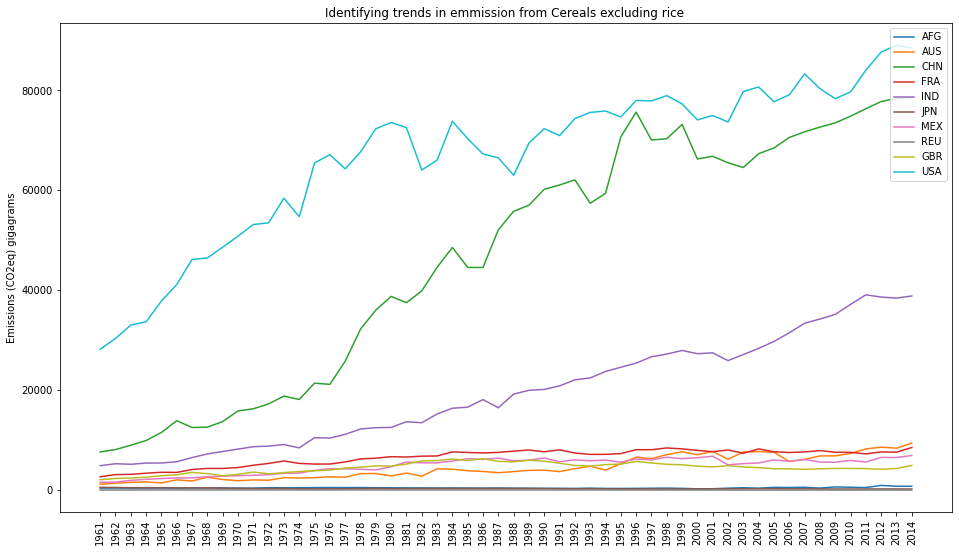

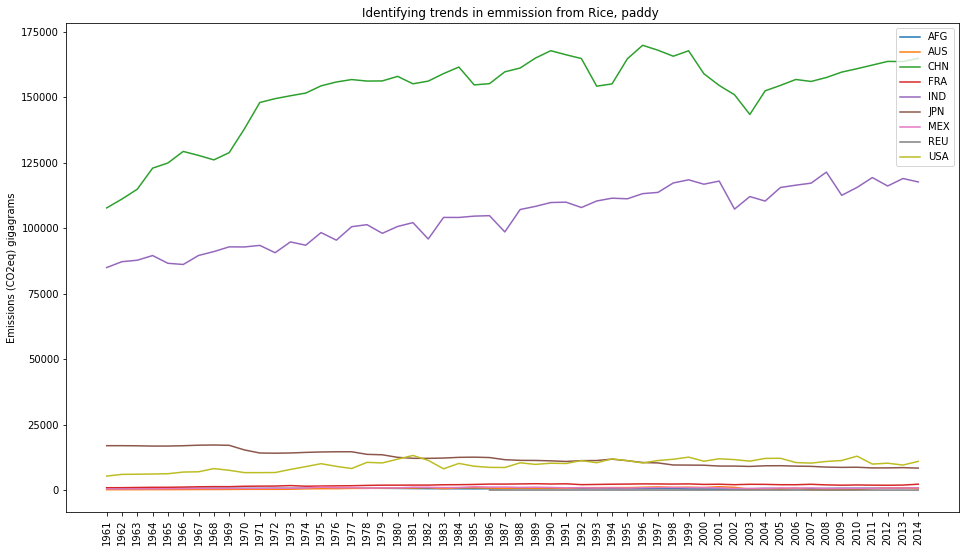

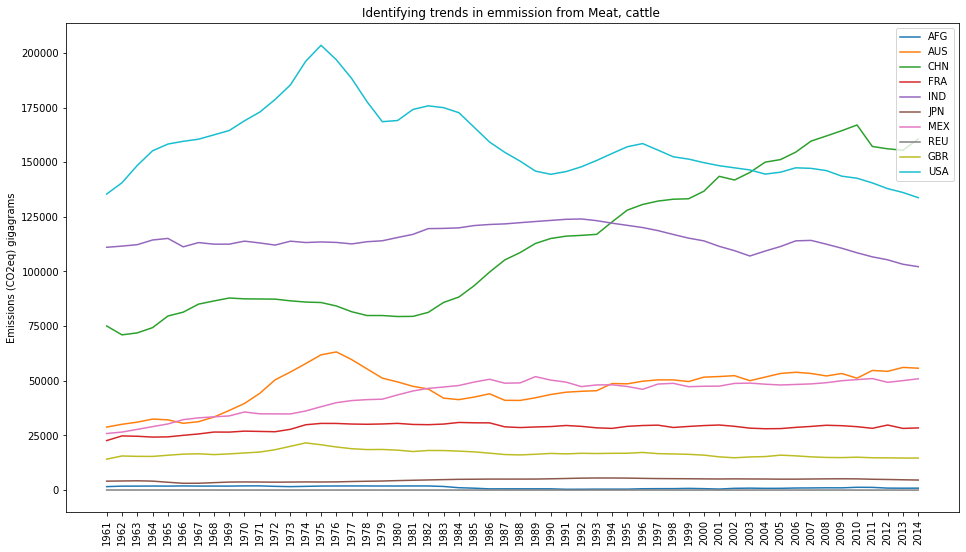

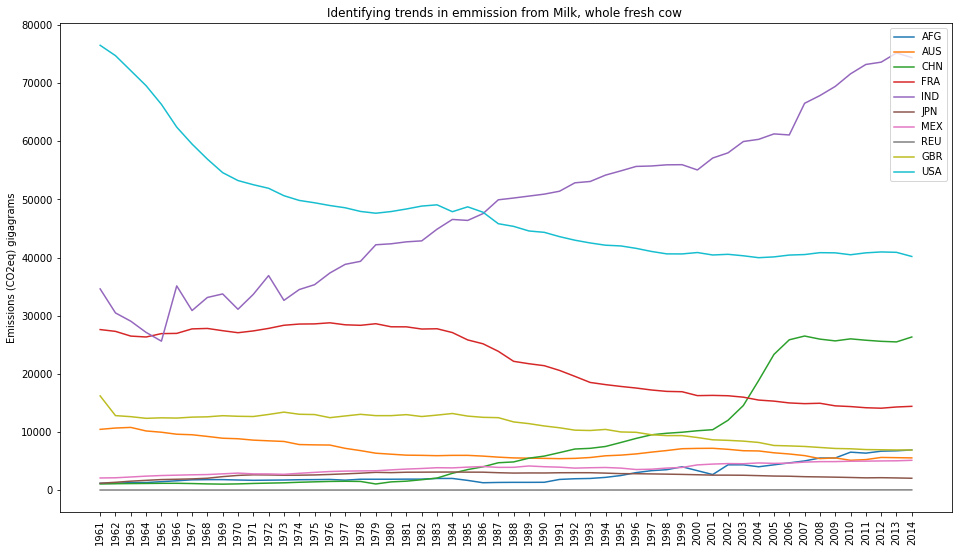

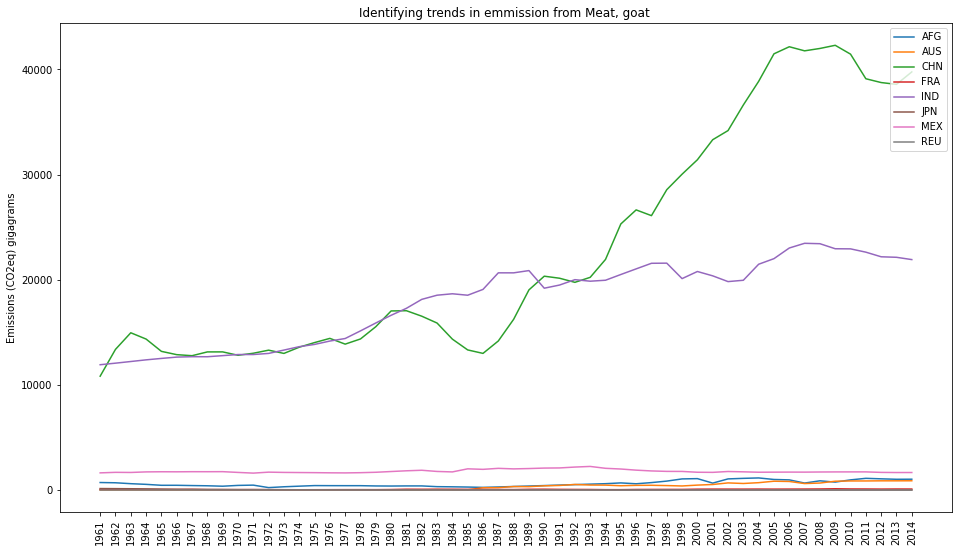

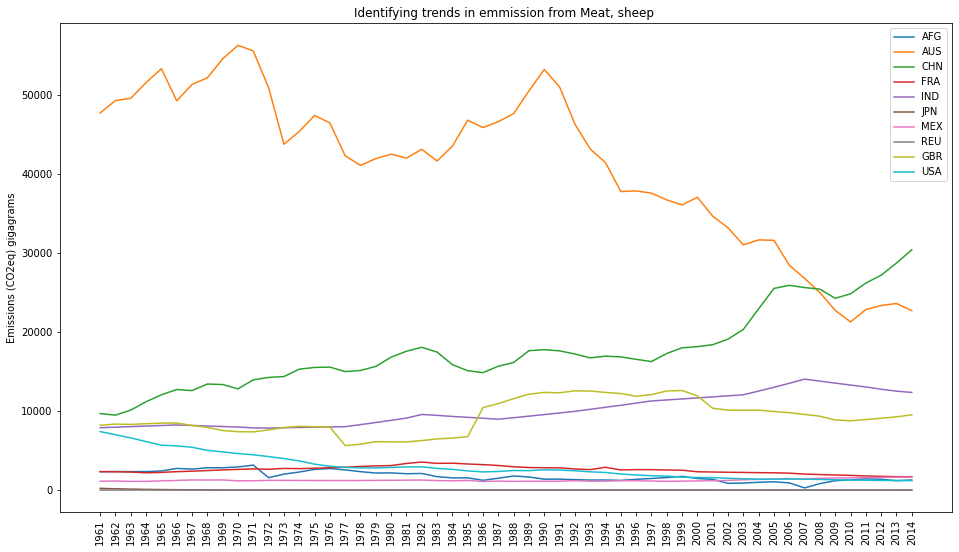

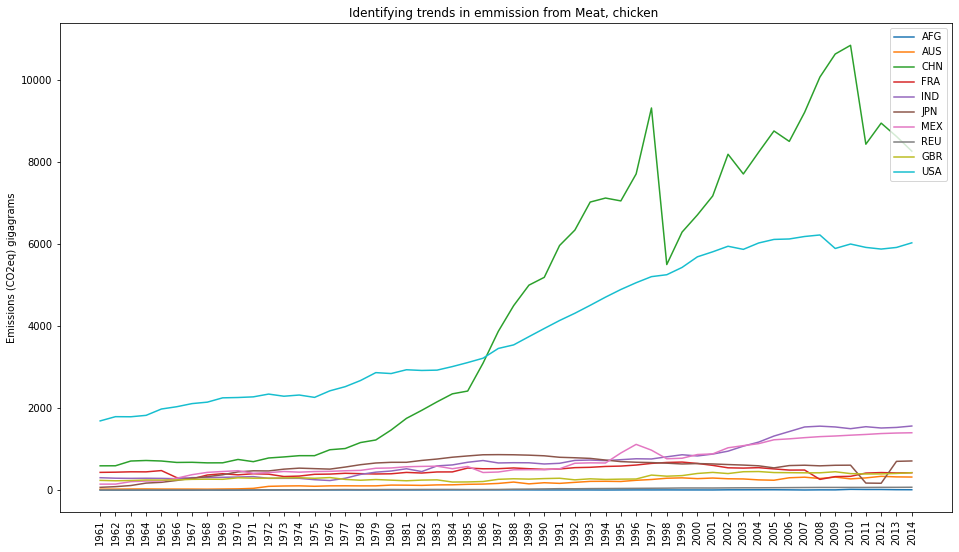

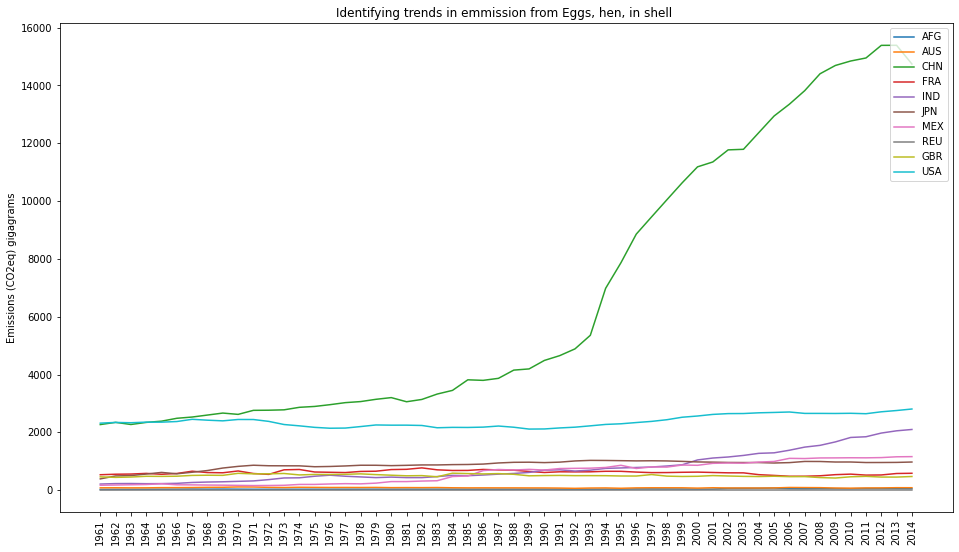

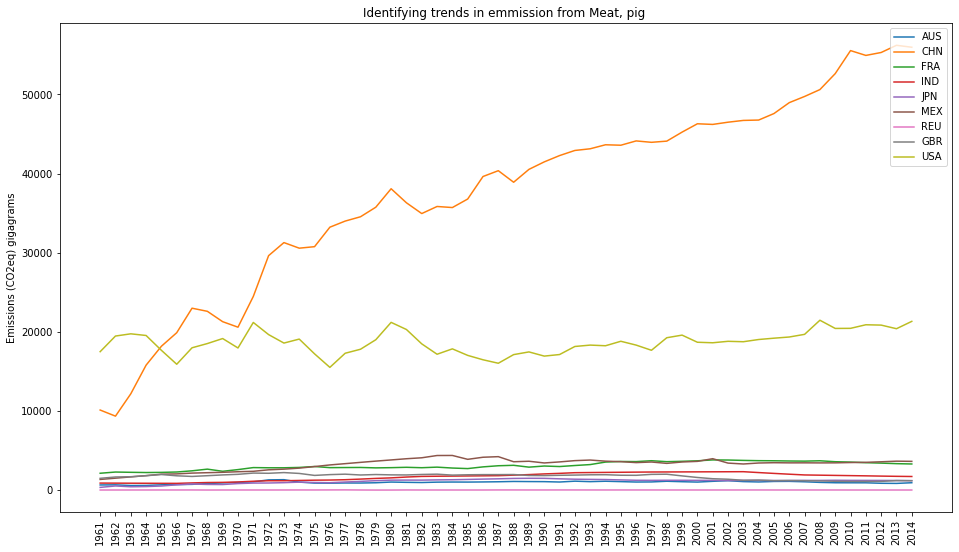

In [11]:
def plotemissioncrop(crop):
    plt.rcParams["figure.figsize"] = [16,9]
    df = selectemission.loc[selectemission['typeName'] == crop]
  #plotting a line graph for each country
    for code in df['code3']:
        country_df = df[df['code3'] == code]
        x = country_df.columns[2:]
        y = country_df[x].values.flatten().tolist()
        plt.plot(x, y, label=code)

  #plt = plt.figure(figsize = (10, 5))
    plt.legend(loc="upper right")
    crop = crop.replace('Emissions (CO2eq) gigagrams','')
    plt.ylabel("Emissions (CO2eq) gigagrams") 
    plt.title("Identifying trends in emmission from {}".format(crop)) 
    plt.xticks(rotation=90)
    plt.show() 
    
crops_list = selectemission['typeName'].unique()
for crops in crops_list:
    plotemissioncrop(crops)

+ `yield` vs `total emission` : how yield and emissions are related. This is the focus area of our project.

<AxesSubplot:xlabel='Country'>

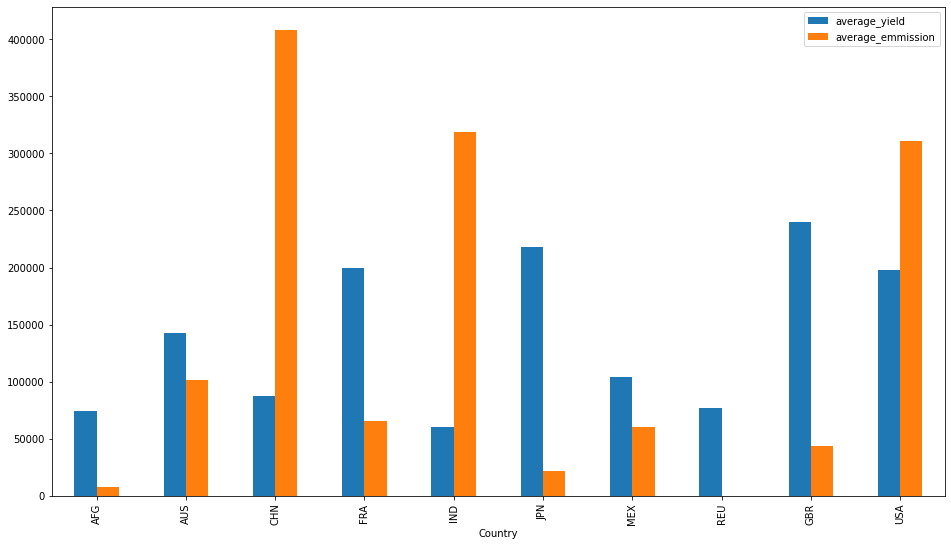

In [12]:
#Creating DF for cumulative yield
average_yield =[]
average_emmission = []
for code in countryincludes:
    countrydf = selectarea.loc[selectarea['code3'] == code]
    year_data = countrydf.columns[2:]
    countrydf['Average Production'] = countrydf[year_data].mean(axis = 1)
    mean = countrydf['Average Production'].mean(axis=0)
    average_yield.append(mean)
    emmission_df = cumemission[cumemission['code3'] == code]
    year_data = cumemission.columns[2:]
    emmission_df['Average Emmission'] = emmission_df[year_data].mean(axis = 1)
    avg = emmission_df['Average Emmission']
    average_emmission.append(float(avg))

cumulativeyield = pd.DataFrame(columns=['Country','average_yield','average_emmission'], data = list(zip(countryincludes, average_yield,average_emmission)))
#cumulativeyield  
fig, ax = plt.subplots()
cumulativeyield.plot.bar(x='Country', ax=ax)

+ `crop production` vs `categorical emissions` : to see which emissions are how much correlated to crop production. can use heatmaps here.

**Now for this we will take up a bit long aproach. We are going to first aggregate the amount of emissions of every country over an year per category.**
**And for crops, we will aggregate the amount of crop yields of every country over an year per category of crop.
So, by the end of this exercise we will have a categorical emission of whole world per year, and the same for crop production.**

**We will later use it to obtain a correlation plot between categories of emissions vs categories of crop.**

In [13]:
selectemission=selectemission.replace(np.NaN,0.0)
selectemission.drop('code3', axis=1)
arri = np.zeros(shape=(9,54))
transforemission = pd.DataFrame(arri, columns= ['1961', '1962', '1963', '1964', '1965', '1966',
       '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975',
       '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984',
       '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993',
       '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002',
       '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011',
       '2012', '2013', '2014'], index=emissionincludes)
for i in emissionincludes:
    arr = np.zeros(shape=(1,54))
    z=selectemission.drop('code3', axis=1)[selectemission.typeName==i].drop('typeName', axis=1)
    z.index = range(len(z))
    z=np.array(z)
    for j in range(len(z)):
        arr+=z[j]
    transforemission.loc[i:i] = arr
selectcrops=selectcrops.replace(np.NaN,0.0)
selectcrops.drop('code3', axis=1)
arri = np.zeros(shape=(10,54))
transforcrops = pd.DataFrame(arri, columns= ['1961', '1962', '1963', '1964', '1965', '1966',
       '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975',
       '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984',
       '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993',
       '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002',
       '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011',
       '2012', '2013', '2014'], index=cropsincludes)
for i in cropsincludes:
    arr = np.zeros(shape=(1,54))
    z=selectcrops.drop('code3', axis=1)[selectcrops.typeName==i].drop('typeName', axis=1)
    z.index = range(len(z))
    z=np.array(z)
    for j in range(len(z)):
        arr+=z[j]
    transforcrops.loc[i:i] = arr
transformemission, transformcrops = transforemission.T, transforcrops.T
transformdata = transformemission.merge(transformcrops, left_index=True, right_index=True)

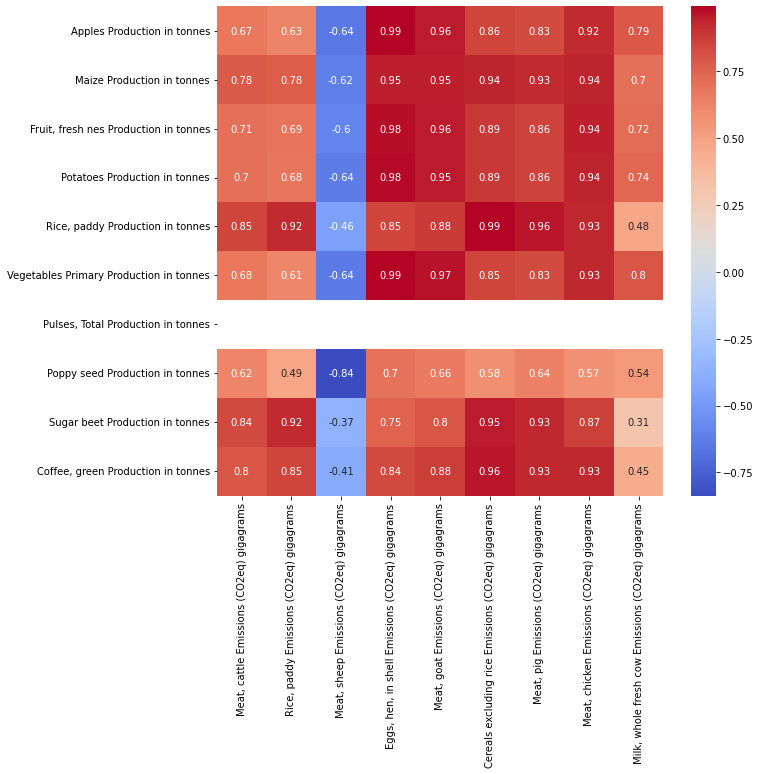

In [14]:
import seaborn as sns
%matplotlib inline
# First let us get the correlation matrix (as a pandas dataframe)
cor = transformdata.corr()
cor = cor.drop(cor.columns[range(9)])
cor = cor.drop(cor.columns[9:], axis=1)
# We did the above three lines of code because we require correlation only between specific pairs.
# We need only between crops vs emissions and not among themselves.
plt.figure(figsize = (10,9))

sns.heatmap(cor, 
            annot = True,
            cmap = 'coolwarm')
plt.show()

This was the end of the notebook. We are done with it.

**Congratulations!**